In [31]:
class candex_geo:

    def __init__(self):
        self.case_name                 =  'case_temp' # name of the case
        self.temp_dir                  =  '../temporary/'
        
    def run_subbasin_creation(self,
                              dem_tif_in,
                              outlet = (-9999,-9999),
                              river_thr = 10000, #starting point in number of cells int
                              dir_tif_in = None,
                              dirmap = (64,  128,  1,   2,    4,   8,    16,  32)): # N, NE, E, SE, S, SW, W, NW):
    
        """
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This functions recives a path to a DEM raster file
        Arguments
        ---------
        raster_path_in: string; the path to the input raster, DEM geotif
        raster_path_out: string; the path to the output raster
        raster_band: int; the band in the raster
        num_bin: int; number of bins to slice min and max 
        slice_level : np.array; strcitly monotonically increasing levels for slicing the raster 
        """
        
        slef.dem_processing (dem_tif_in,
                             dir_tif_in = None,
                             dirmap = dirmap)
        
        self.river (dir_tif_in,
                    acc_tif_in,
                    shp_river_out,
                    dirmap = dirmap,
                    pour_point = outlet,
                    snap_pour_point_thr = 100,
                    river_start_thr = river_thr)
        
        river_network(  infile_river,
                        outfile_river,
                        dem_tif_in = None,
                        acc_tif_in = None):
 
    
    
    
    def zonal_stat(self,
                   vector_path,
                   raster_path,
                   raster_band = 1,
                   nodata_value = None):
        """
        original code:
        Zonal Statistics
        Vector-Raster Analysis
        Copyright 2013 Matthew Perry
        Usage:
          zonal_stats.py VECTOR RASTER
          zonal_stats.py -h | --help
          zonal_stats.py --version
        Options:
          -h --help     Show this screen.
          --version     Show version.
        modified by:
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function creates a geopandas dataframe of lat, lon and IDs provided
        Arguments
        ---------
        vector_path: string; the path to the shapefile
        raster_path: string; the path to the raster
        raster_band: int, the band in the raster to be used for zonal statistics
        nodata_value: no data value in raster to be ingnored
        global_src_extent : set as False
        Returns
        -------
        shp: geodataframe, with values of mean, max, min, sum, std, count, fid for each shape in shapefile
        """
        from osgeo import gdal, ogr
        # from osgeo.gdalconst import *
        import osgeo.gdalconst
        import numpy as np
        import sys
        gdal.PushErrorHandler('CPLQuietErrorHandler')
        import pandas as pd
        import os
        import geopandas as gpd
        # set hardcoded value
        global_src_extent = False
        # read the ratster file band number n
        rds = gdal.Open(raster_path, osgeo.gdalconst.GA_ReadOnly)
        assert(rds)
        rb = rds.GetRasterBand(band)
        rgt = rds.GetGeoTransform()
        # if nodata_value is identified
        if nodata_value:
            nodata_value = float(nodata_value)
            rb.SetNoDataValue(nodata_value)
        # read vector data
        vds = ogr.Open(vector_path, osgeo.gdalconst.GA_ReadOnly)  # TODO maybe open update if we want to write stats
        assert(vds)
        vlyr = vds.GetLayer(0)
        # create an in-memory numpy array of the source raster data
        # covering the whole extent of the vector layer
        if global_src_extent:
            # use global source extent
            # useful only when disk IO or raster scanning inefficiencies are your limiting factor
            # advantage: reads raster data in one pass
            # disadvantage: large vector extents may have big memory requirements
            src_offset = self.bbox_to_pixel_offsets(rgt, vlyr.GetExtent())
            src_array = rb.ReadAsArray(*src_offset)
            # calculate new geotransform of the layer subset
            new_gt = (
                (rgt[0] + (src_offset[0] * rgt[1])),
                rgt[1],
                0.0,
                (rgt[3] + (src_offset[1] * rgt[5])),
                0.0,
                rgt[5]
            )
        mem_drv = ogr.GetDriverByName('Memory')
        driver = gdal.GetDriverByName('MEM')
        # Loop through vectors
        stats = []
        feat = vlyr.GetNextFeature()
        while feat is not None:
            if not global_src_extent:
                # use local source extent
                # fastest option when you have fast disks and well indexed raster (ie tiled Geotiff)
                # advantage: each feature uses the smallest raster chunk
                # disadvantage: lots of reads on the source raster
                src_offset = self.bbox_to_pixel_offsets(rgt, feat.geometry().GetEnvelope())
                src_array = rb.ReadAsArray(*src_offset)
                # calculate new geotransform of the feature subset
                new_gt = (
                    (rgt[0] + (src_offset[0] * rgt[1])),
                    rgt[1],
                    0.0,
                    (rgt[3] + (src_offset[1] * rgt[5])),
                    0.0,
                    rgt[5]
                )
            if src_array is not None:
                # Create a temporary vector layer in memory
                mem_ds = mem_drv.CreateDataSource('out')
                mem_layer = mem_ds.CreateLayer('poly', None, ogr.wkbPolygon)
                mem_layer.CreateFeature(feat.Clone())
                # Rasterize it
                rvds = driver.Create('', src_offset[2], src_offset[3], 1, gdal.GDT_Byte)
                rvds.SetGeoTransform(new_gt)
                gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
                rv_array = rvds.ReadAsArray()
                # Mask the source data array with our current feature
                # we take the logical_not to flip 0<->1 to get the correct mask effect
                # we also mask out nodata values explictly
                masked = np.ma.MaskedArray(
                    src_array,
                    mask=np.logical_or(
                        src_array == nodata_value,
                        np.logical_not(rv_array)
                    )
                )
                feature_stats = {
                    'min': float(masked.min()),
                    'mean': float(masked.mean()),
                    'max': float(masked.max()),
                    'std': float(masked.std()),
                    'sum': float(masked.sum()),
                    'count': int(masked.count()),
                    'fid': int(feat.GetFID())}
            else:
                feature_stats = {
                    'min': 'NaN',
                    'mean': 'NaN',
                    'max': 'NaN',
                    'std': 'NaN',
                    'sum': 'NaN',
                    'count': 'NaN',
                    'fid': 'NaN'}
            stats.append(feature_stats)
            rvds = None
            mem_ds = None
            feat = vlyr.GetNextFeature()
        vds = None
        rds = None
        stats = pd.DataFrame(stats)
        shp = gpd.read_file(vector_path)
        shp ['min'] = stats['min'].astype(float)
        shp ['mean'] = stats['mean'].astype(float)
        shp ['max'] = stats['max'].astype(float)
        shp ['std'] = stats['std'].astype(float)
        shp ['sum'] = stats['sum'].astype(float)
        shp ['count'] = stats['count'].astype(float)
        shp ['fid'] =  stats['fid'].astype(float)
        return shp
    
    def bbox_to_pixel_offsets(self,gt, bbox):
        """
        Zonal Statistics
        Vector-Raster Analysis
        Copyright 2013 Matthew Perry
        Usage:
          zonal_stats.py VECTOR RASTER
          zonal_stats.py -h | --help
          zonal_stats.py --version
        Options:
          -h --help     Show this screen.
          --version     Show version.
        """
        originX = gt[0]
        originY = gt[3]
        pixel_width = gt[1]
        pixel_height = gt[5]
        x1 = int((bbox[0] - originX) / pixel_width)
        x2 = int((bbox[1] - originX) / pixel_width) + 1
        y1 = int((bbox[3] - originY) / pixel_height)
        y2 = int((bbox[2] - originY) / pixel_height) + 1
        xsize = x2 - x1
        ysize = y2 - y1
        return (x1, y1, xsize, ysize)

    def geotif_zones(self,
                     raster_path_in,
                     raster_path_out,
                     raster_band =1,
                     num_bin=10,
                     slice_level = None):
        """
        original code by:
        Andrea Massetti;
        https://gis.stackexchange.com/questions/164853/reading-modifying-and-writing-a-geotiff-with-gdal-in-python
        modified by:
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function creates a raster file based on assiging single values to a given range of cell values;
        example is creating elevation zone based on a raster file of digital elevation models (DEMs)
        Arguments
        ---------
        raster_path_in: string; the path to the input raster
        raster_path_out: string; the path to the output raster
        raster_band: int; the band in the raster
        num_bin: int; number of bins to slice min and max 
        slice_level : np.array; strcitly monotonically increasing levels for slicing the raster 
        """
        # read the ratster file band number n
        import os
        import gdal
        import numpy as np
        ds = gdal.Open(raster_path_in)
        band = ds.GetRasterBand(raster_band)
        arr = band.ReadAsArray()
        [cols, rows] = arr.shape
        arr_min = arr.min()
        arr_max = arr.max()
        print(arr_min, arr_max)
        if slice_level is None: # calculate the delta from min to max with number of bins
            delta = np.arange(arr_min, arr_max, (arr_max-arr_min)/num_bin)
        else:
            # check if slice_level is monotonically increasing
            slice_level = slice_level.flatten()
            if slice_level.ndim != 1:
                sys.exit('it seems the provided slice levels are not 1 dimentional numpy array')
            if len(slice_level) != len(np.unique(slice_level)):
                sys.exit('it seems the provided slice levels do not have unique values')
            if not np.all(np.diff(slice_level) > 0):
                sys.exit('it seems the provided slice levels are not in increasing order')
            delta = slice_level
            # check values:
            if (arr_min > delta.max()) or (arr_max < delta.min()):
                print('max from geotiff: ', arr_max, 'min from geotiff: ', arr_min)
                sys.exit('it seems the provided bound specified by slice_level is outside of raster max to min values')
        arr_out = arr
        for i in np.arange(len(delta)-1):
            arr_out = np.where(np.logical_and(arr_out>=delta[i], arr_out<=delta[i+1]), (delta[i]+delta[i+1])/2,arr_out)
        # saving
        driver = gdal.GetDriverByName("GTiff")
        outdata = driver.Create(raster_path_out, rows, cols, 1, gdal.GDT_UInt16)
        outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
        outdata.SetProjection(ds.GetProjection())##sets same projection as input
        outdata.GetRasterBand(1).WriteArray(arr_out)
        outdata.GetRasterBand(1).SetNoDataValue(0)
        outdata.FlushCache()
        outdata = None
        band=None
        ds=None

    def geotif2shp(self,
                   raster_path_in,
                   vector_path_out,
                   raster_band = 1,
                   name_of_filed = 'values'):
        """
        original code by:
        Kadir Şahbaz;
        https://gis.stackexchange.com/questions/281073/excluding-extent-when-polygonizing-raster-file-using-python
        and
        https://gis.stackexchange.com/questions/254410/raster-to-vector-conversion-using-gdal-python
        modified by:
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function reads a raster file in geotiff and return vector values refering to that raster
        Arguments
        ---------
        raster_path_in: string; the path to the input raster
        raster_path_out: string; the path to the output raster
        raster_band: int; the band in the raster
        num_bin: int; number of bins to slice min and max 
        slice_level : np.array; strcitly monotonically increasing levels for slicing the raster 
        """
        from osgeo import gdal, ogr
        # this allows GDAL to throw Python Exceptions
        #gdal.UseExceptions()
        src_ds = gdal.Open(raster_path_in)
        srs.ImportFromWkt(src_ds.GetProjection())
        srcband = src_ds.GetRasterBand(raster_band)
        drv = ogr.GetDriverByName('ESRI Shapefile')
        dst_ds = drv.CreateDataSource(vector_path_out)
        dst_layer = dst_ds.CreateLayer(vector_path_out , srs=srs)
        fd = ogr.FieldDefn(name_of_filed, ogr.OFTInteger)
        dst_layer.CreateField(fd)
        dst_field = dst_layer.GetLayerDefn().GetFieldIndex(name_of_filed)
        gdal.Polygonize(srcband, None, dst_layer, dst_field, [], callback=None)

    def voronoi_diagram(self,
                        infile_shp_points,
                        outfile_shp_voronoi,
                        buffer = 2):
        """
        original code by:
        Abdishakur
        https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
        modified by:
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function reads a shapefile of points and return the Thiessen or Voronoi polygons
        ---------
        raster_path_in: string; the path to the input raster
        raster_path_out: string; the path to the output raster
        raster_band: int; the band in the raster
        num_bin: int; number of bins to slice min and max 
        slice_level : np.array; strcitly monotonically increasing levels for slicing the raster 
        """
        import shapefile # as part of pyshp
        import geovoronoi
        import os
        from   shapely.geometry import Polygon
        import numpy as np
        import geopandas as gpd
        # read the shapefile
        stations = gpd.read_file(infile_shp_points)
        # get the crs
        crs_org = stations.crs
        # add the ID_t to the point shapefiles
        stations ['ID_s'] = np.arange(len(stations))+1
        stations ['ID_s'] = stations ['ID_s'].astype(float)
        # get the total boundary of the shapefile
        stations_buffert = stations.buffer(buffer) # add a buffer
        minx, miny, maxx, maxy = stations_buffert.total_bounds
        # create the bounding shapefile
        parts = []
        with shapefile.Writer('test.shp') as w:
            w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
            w.field("ID_bounding",'N') # create (N)umerical attribute fields, integer
            # creating the polygon given the lat and lon
            parts.append([ (minx, miny),\
                           (minx, maxy), \
                           (maxx, maxy), \
                           (maxx, miny), \
                           (minx, miny)])
            # store polygon
            w.poly(parts)
            # update records/fields for the polygon
            w.record(1)
        boundary = gpd.read_file('test.shp')
        os.remove('test.dbf');os.remove('test.shx');os.remove('test.shp')
        # create the voroni diagram for given point shapefile
        coords = geovoronoi.points_to_coords(stations.geometry)
        poly_shapes, location = \
        geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)
        # pass te polygons to shapefile
        Thiessen = gpd.GeoDataFrame()
        Thiessen['ID'] = None
        for i in np.arange(len(poly_shapes)):
            Thiessen.loc[i, 'geometry'] = Polygon(poly_shapes[i])
            Thiessen.loc[i, 'ID_s']     = stations.iloc[location[i][0]].ID_s.astype(float)
        Thiessen = Thiessen.sort_values(by='ID_s')# sort on values
        stations = stations.drop(columns='geometry')
        Thiessen = pd.merge_asof(Thiessen, stations, on='ID_s') #, direction='nearest')
        Thiessen = Thiessen.set_geometry('geometry') #bring back the geometry filed; pd to gpd
        Thiessen = Thiessen.set_crs(crs_org)#
        Thiessen.to_file(outfile_shp_voronoi)
    
    def dem_processing (self,
                        dem_tif_in,
                        dir_tif_in = None, #TODO: include if user give dir_tif_in
                        dirmap = (64,  128,  1,   2,    4,   8,    16,  32)): # N, NE, E, SE, S, SW, W, NW
        """
        original code by:
        pysheds developer team
        https://github.com/mdbartos/pysheds
        modified by:
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function reads a dem (or also a direction file and map) and generate the dir file, and flow accumualtion
        ---------
        dem_tif_in: string; the path to the input raster
        dir_tif_in: string; the path to the output raster
        dirmap: int; the band in the raster
        num_bin: int; number of bins to slice min and max 
        slice_level : np.array; strcitly monotonically increasing levels for slicing the raster 
        """
        from pysheds.grid import Grid
        import geopandas as gpd
        import json
        import numpy as np
        import os
        grid = Grid.from_raster(dem_tif_in, data_name='dem') # part of Missouri River
        grid.fill_depressions(data='dem', out_name='flooded_dem')
        grid.resolve_flats('flooded_dem', out_name='inflated_dem') #resolve the flats
        grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
        # Add new dir to grid as float and save in temporary folder
        print('direction map is not provided; candex will calculate flow direction and save in temporary file:')
        print('candex will save the direction file here: ', self.temp_dir+self.case_name+'_dir.tif')
        grid.add_gridded_data(grid.dir.astype(float), data_name='dir_new', affine=grid.affine,
                              shape=grid.dem.shape, crs=grid.crs, nodata=grid.dir.nodata)
        grid.to_raster('dir_new', self.temp_dir+self.case_name+'_dir.tif' , view=False)
        grid.accumulation(data='dir', out_name='acc')
        # Add new dir to grid as float
        grid.add_gridded_data(grid.acc.astype(float), data_name='acc_new', affine=grid.affine,
                              shape=grid.dem.shape, crs=grid.crs, nodata=grid.acc.nodata)
        print('candex will save the accumulation file here: ', self.temp_dir+self.case_name+'_acc.tif')
        grid.to_raster('acc_new', self.temp_dir+self.case_name+'_acc.tif' , view=False)
        
    def river  (self,
                dir_tif_in,
                acc_tif_in,
                shp_river_out,
                dirmap = (64,  128,  1,   2,    4,   8,    16,  32), # N, NE, E, SE, S, SW, W, NW
                pour_point = (-9999,-9999), # lon and lat of the outlet
                snap_pour_point_thr = 100, # threshold for snap the outlet to river network
                river_start_thr = 100): # starting river netwrok threshold in number of grids
        """
        original code by:
        pysheds developer team
        https://github.com/mdbartos/pysheds
        modified by:
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function reads direction and flow accumulation and the most downstream point and threshold
        ---------
        dir_tif_in: string; the path to the direction geotif
        acc_tif_in: string; the path to the flow accumulation geotif
        shp_river_out: string; the path to the river network to be saved
        dirmap: int; direction of each value in flow direction file
        pour_point: (lon,lat); the most downstream location 
        snap_pour_point_thr: int; the maximum flow accumulation for correcting to the river segment in cell
        river_start_thr: int; starting point of river network for more than an accumulation value
        """
        from pysheds.grid import Grid
        import geopandas as gpd
        import json
        import numpy as np
        import os
        #
        grid = Grid.from_raster(dir_tif_in, data_name='dir') 
        grid1 = Grid.from_raster(acc_tif_in, data_name='acc')
        grid.add_gridded_data(grid1.acc, data_name='acc', affine=grid.affine,
                              shape=grid.shape, crs=grid.crs, nodata=np.nan)
        # putting the outlet point exactly on the river network
        xy = np.column_stack([pour_point[0], pour_point[1]])
        new_xy = grid.snap_to_mask(grid.acc > snap_pour_point_thr, xy, return_dist=False)
        new_xs, new_ys = new_xy[:,0], new_xy[:,1]
        # Delineate the catchment
        grid.catchment(data='dir', x=new_xs, y=new_ys, dirmap=dirmap, out_name='catch',\
                       nodata=grid.dir.nodata,\
                       recursionlimit=1500000, xytype='label')
        grid.clip_to('catch') # must be clipped
        # Compute accumulation
        grid.accumulation(data='catch', out_name='acc')
        branches = None
        branches = grid.extract_river_network(fdir='catch',
                                              acc='acc',
                                              threshold=river_start_thr,
                                              dirmap=dirmap)
        for branch in branches['features']:
            line = np.asarray(branch['geometry']['coordinates'])
        # dumpt the lines into a network
        with open(self.temp_dir+'/test.json', 'w') as json_file:
            json.dump(branches, json_file)
        # load the json and save it as a shapefile using geopandas
        shp = gpd.read_file(self.temp_dir+'/test.json')
        os.remove (self.temp_dir+'/test.json')
        shp['ID'] = np.arange(len(shp)) + 1
        # save the shapefile
        shp.to_file('../temporary/test.shp')

    def river_network(  self,
                        infile_river,
                        outfile_river,
                        dem_tif_in = None,
                        acc_tif_in = None):

        import geopandas as gpd
        import pandas as pd
        import numpy as np
        from shapely.geometry import Point
        #
        shp = gpd.read_file(infile_river)
        # creat additional fields for network topology data
        shp['start_lat'] = None
        shp['start_lon'] = None
        shp['end_lat']   = None
        shp['end_lon']   = None
        shp['end_lat_b'] = None
        shp['end_lon_b'] = None
        shp['Down_ID']   = -9999
        shp['Up_ID']     = None
        shp['Up1_ID']    = None
        shp['Up2_ID']    = None
        shp['Up3_ID']    = None
        shp['Up4_ID']    = None
        shp['Up5_ID']    = None
        # popolating the fileds
        for index, row in shp.iterrows():
            line = np.asarray(row['geometry'])
            # populate the filed
            shp['start_lat'].iloc[index] = line[-1,1]
            shp['start_lon'].iloc[index] = line[-1,0]
            shp['end_lat'].iloc[index]   = line[0,1]
            shp['end_lon'].iloc[index]   = line[0,0]
            shp['end_lat_b'].iloc[index] = line[1,1] # one before merged point not to include all the contributing area of confluence
            shp['end_lon_b'].iloc[index] = line[1,0] # one before merged point not to include all the contributing area of confluence
        for index, row in shp.iterrows():
            # get the end lat, lon of a river segment
            end_lat = shp['end_lat'].iloc[index]
            end_lon = shp['end_lon'].iloc[index]
            # find which segment start with that lat, lon
            indy = shp.index[shp['start_lat'] == end_lat].tolist()
            indx = shp.index[shp['start_lon'] == end_lon].tolist()
            # find the end of indy and indx
            ind = list(set(indy).intersection(indx))
            # assign the list of downstream segment to the field if no downstream -9999
            if str(ind).strip('[]') != '':
                shp['Down_ID'].loc[index] = shp['ID'].iloc[int(str(ind).strip('[]'))]
            else:
                shp['Down_ID'].loc[index] = -9999
        # creat a list of immidiate upstream
        for index, row in shp.iterrows():
            # get the ID of the river segment
            ID = shp['ID'].loc[index]
            # find the immidate upstream
            ind = shp.index[shp['Down_ID'] == ID]
            indup = shp['ID'].iloc[ind].tolist()
            shp['Up_ID'] = str(indup)
            # assign the upstream list
            for i in np.arange(len(indup)):
                field_name = 'Up'+str(i+1)+'_ID'
                shp[field_name].loc[index] = indup[i]
        if dem_tif_in:
            values = self.extract_value_tiff (np.array(shp['start_lon'])+0.0004,
                                              np.array(shp['start_lat'])-0.0004,
                                              dem_tif_in)
            shp['start_ele'] = values
            values = self.extract_value_tiff (np.array(shp['end_lon'])+0.0004,
                                              np.array(shp['end_lat'])-0.0004,
                                              dem_tif_in)
            shp['end_ele'] = values
        if acc_tif_in:
            values = self.extract_value_tiff (np.array(shp['end_lon_b'])+0.0004,
                                              np.array(shp['end_lat_b'])-0.0004,
                                              acc_tif_in)
            shp['end_acc'] = values
        # save the shapefile
        shp_t = shp.to_crs ("EPSG:6933")
        shp['length'] = shp_t.geometry.length
        shp.to_file(outfile_river)
        
    def extract_value_tiff (  self,
                              lon_in,
                              lat_in,
                              tif_in):
        
        import rasterio
        import geopandas as gpd
        import numpy as np
        # https://gis.stackexchange.com/questions/317391/python-extract-raster-values-at-point-locations/324830
        # Initialize coords
        coords = np.zeros([len(lon_in),2])
        coords[:,0] = lon_in
        coords[:,1] = lat_in
        # Open the raster and store metadata
        src = rasterio.open(tif_in)
        # Sample the raster at every point location and store values in DataFrame
        values = [x for x in src.sample(coords)]
        return np.array(values)
    
    def get_all_downstream (self,
                            seg_IDs,
                            down_IDs):
        """
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function get a 1-D array of numpy arrays of river reach ID and a similar 1-D array
        of downstream river reach ID
        Arguments
        ---------
        seg_IDs: the 1D array of seg id [n,]
        down_IDs: the 1D array of downstream seg id [n,]
        Returns
        -------
        Array: the 2D array of downsream seg id s [n,1000] 1000 is maximume number of downstream
        """
        import pandas as pd
        import numpy as np
        #
        NTOPO = np.empty([len(seg_IDs),1000]) # create the empty array with length of seg_IDs and 1000
        NTOPO [:] = np.nan # populate with nan
        NTOPO [:,0] = seg_IDs # assign the first colomn as seg id
        # loop over the seg_IDs
        for i in np.arange(len(seg_IDs)):
            ID = seg_IDs [i] # get the seg ID
            down_ID = down_IDs [i] # get the seg downstream ID
            if down_ID in seg_IDs: # check if the downstream seg is part of river network
                down_stream_exists = True
            else:
                down_stream_exists = False
            m = 1 # initialize m
            while down_ID > 0 and down_stream_exists: # while not the last segment
                # update the ID and ID down
                idx = np.where (seg_IDs == down_ID) # get the index of the segment that is downstream
                ID = seg_IDs [idx] # update the ID
                down_ID = down_IDs [idx] # update the downstream
                if down_ID in seg_IDs:
                    down_stream_exists = True
                else:
                    down_stream_exists = False
                NTOPO[i,m] = ID
                m += 1
        return NTOPO
    
    def get_all_upstream(   self,
                            seg_ID,
                            seg_IDs,
                            down_IDs):
        """
        @ author:                  Shervan Gharari
        @ Github:                  https://github.com/ShervanGharari/candex
        @ author's email id:       sh.gharari@gmail.com
        @ license:                 GNU-GPLv3
        This function get a 1-D array of numpy arrays of river reach ID and a similar 1-D array
        of downstream river reach ID
        Arguments
        ---------
        seg_IDs: the 1D array of seg id [n,]
        down_IDs: the 1D array of downstream seg id [n,]
        Returns
        -------
        Array: the 2D array of downsream seg id s [n,1000] 1000 is maximume number of downstream
        """
        import pandas as pd
        import numpy as np
        #
        downstreams = self.get_all_downstream(seg_IDs, down_IDs)
        print(downstreams)
        upstreams = np.array([])
        # loop over the rows and find the rows that the seg_ID is mentioned in them
        for i in np.arange(len(seg_IDs)):
            # get rows
            row = downstreams[i,:].flatten()
            # check if seg_ID is in the row
            if seg_ID in row:
                upstreams = np.append (upstreams, row[0])
        return upstreams
    
    def subbasin_creation(  self,
                            dir_tif_in,
                            river_shp_in,
                            subbasin_tiff_out,
                            dirmap = (64,  128,  1,   2,    4,   8,    16,  32)#N, NE, E, SE, S, SW, W, NW
                            ): 
        from pysheds.grid import Grid
        import geopandas as gpd
        import json
        import numpy as np
        import os
        
        grid = Grid.from_raster(dir_tif_in, data_name='dir')
        A = gpd.read_file(river_shp_in)
        # sort based on accumulation
        A['end_lat_b'] = A['end_lat_b'].astype(float)
        A['end_lon_b'] = A['end_lon_b'].astype(float)
        A = A.sort_values(by='end_acc')
        A = A.reset_index(drop=True)
        # initializing the sub_basin raster
        z1 = np.zeros(grid.shape)
        # loop over each segment of the river
        for index, row in A.iterrows():
            print(index)
            cat_ID = A['ID'].iloc[index] # get the ID of that river segment
            c = grid.catchment(A['end_lon_b'].iloc[index], A['end_lat_b'].iloc[index], \
                               data='dir', dirmap=dirmap, xytype='label', inplace=False)
            z1 += cat_ID * (c != 0).astype(int)
            idx = np.where(c != 0)
            grid.dir[idx] = grid.dir.nodata
        # Add z1 to grid
        idx = np.where(z1 == 0)
        z1[idx] = np.nan
        grid.add_gridded_data(z1, data_name='sub_basin', affine=grid.affine,
                              shape=grid.shape, crs=grid.crs, nodata=np.nan)
        # Write to raster
        grid.to_raster('sub_basin', subbasin_tiff_out, view=False)

        

In [32]:
cndxg = candex_geo()
import numpy as np
# cndxg.extract_value (np.array([-114.127]),
#                np.array([51.054]),
#               '../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff.tif')

# cndxg.river_network  ('../temporary/case_temp_dir.tif',
#                       '../temporary/case_temp_acc.tif',
#                         pour_point = (-114.127,51.054), # lon and lat of the outlet
#                         snap_pour_point_thr = 100, # threshold for snap the outlet to river network
#                         river_start_thr = 100000)

# cndxg.NTOPO_creation( '../temporary/test.shp',
#                       '../temporary/test1.shp',
#                       dem_tif_in = '../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff.tif',
#                       acc_tif_in = '../temporary/case_temp_acc.tif')

# cndxg.subbasin_creation(    '../temporary/case_temp_dir.tif',
#                             '../temporary/test1.shp',
#                             '../temporary/subbasins.tif',
#                             dirmap = (64,  128,  1,   2,    4,   8,    16,  32)#N, NE, E, SE, S, SW, W, NW
#                             )
# cndxg.geotif2shp ('../temporary/subbasins.tif',
#                   '../temporary/subbasins.shp')

import geopandas as gdp
shp = gdp.read_file('../temporary/test1.shp')
IDs = np.array(shp['ID'])
down_IDs = np.array(shp['Down_ID'])
# cndxg.get_all_downstream (IDs,down_IDs)
cndxg.get_all_upstream (9,IDs,down_IDs)



[[ 1.  8.  9. ... nan nan nan]
 [ 2.  4.  6. ... nan nan nan]
 [ 3.  9.  5. ... nan nan nan]
 ...
 [ 9.  5.  4. ... nan nan nan]
 [10.  8.  9. ... nan nan nan]
 [11.  5.  4. ... nan nan nan]]
[ 1.  3.  8.  9. 10.]


In [27]:
cndxg = candex_geo()

# cndxg.geotif2shp('../Data/land_cover/NA_MCD12Q1_mode_of_years.tif',
#                 '../Data/land_cover/NA_MCD12Q1_mode_of_years.shp')


# cndxg.dem_processing (  '../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff.tif')

cndxg.river_network  ('../temporary/case_temp_dir.tif',
                      '../temporary/case_temp_acc.tif',
                        pour_point = (-114.127,51.054), # lon and lat of the outlet
                        snap_pour_point_thr = 100, # threshold for snap the outlet to river network
                        river_start_thr = 100)


#                         river_shp_out = '../data/MERIT_HYDRO_dem/river_network',
#                         pour_point = (-114.127,51.054), # Bow at Calgary
#                         snap_pour_point_thr = 1000,
#                         river_start_thr = 1000)

# cndxg.NTOPO_creation( '../data/MERIT_HYDRO_dem/river_network',
#                 '../data/MERIT_HYDRO_dem/river_network_topology',
#                 '../data/MERIT_HYDRO_dem/virtual_gauges')

# cndxg.subbasin_creation(cndxg.temp_dir+cndxg.case_name+'_dir.tif',
#                   '../data/MERIT_HYDRO_dem/river_network_topology',
#                   '../data/MERIT_HYDRO_dem/subbasin.tif')


In [30]:
from pysheds.grid import Grid
import geopandas as gpd
import json
import numpy as np
import os
#
grid = Grid.from_raster('../temporary/case_temp_dir.tif', data_name='dir') 
grid1 = Grid.from_raster('../temporary/case_temp_acc.tif', data_name='acc') 


print(grid.cellsize)



0.0008335091991342122


In [36]:
grid.

<bound method Grid.view of <pysheds.grid.Grid object at 0x7ff8e65d9760>>

In [41]:
from osgeo import gdal,osr
ds=gdal.Open('../temporary/case_temp_dir.tif')
prj=ds.GetProjection()
print (prj.lower())
print(type(prj.lower()))
#




geogcs["wgs 84",datum["wgs_1984",spheroid["wgs 84",6378137,298.257223563,authority["epsg","7030"]],authority["epsg","6326"]],primem["greenwich",0],unit["degree",0.0174532925199433,authority["epsg","9122"]],axis["latitude",north],axis["longitude",east],authority["epsg","4326"]]
<class 'str'>


      ID        lat         lon  \
0      1  49.627953 -114.565641   
1      2  49.632208 -113.932166   
2      3  50.125601 -113.151587   
3      4  50.200421 -112.791051   
4      5  49.943092 -112.529911   
..   ...        ...         ...   
412  413  49.909339 -111.281874   
413  414  50.463768 -111.376871   
414  415  50.382462 -111.294185   
415  416  50.018842 -111.240478   
416  417  49.944560 -111.088148   

                                              geometry          min  \
0    POLYGON ((-114.45500 49.52083, -114.45750 49.5...  1270.099976   
1    POLYGON ((-113.92500 49.54333, -113.92500 49.5...  1038.800049   
2    POLYGON ((-113.10750 50.12159, -113.10750 50.1...   899.500000   
3    MULTIPOLYGON (((-112.75000 50.17083, -112.7516...   818.299988   
4    POLYGON ((-112.47250 49.98167, -112.46750 49.9...   772.900024   
..                                                 ...          ...   
412  POLYGON ((-111.19250 49.87083, -111.19250 49.8...   687.700012   
413  POLYGO

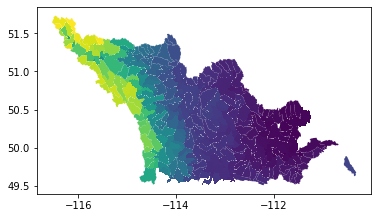

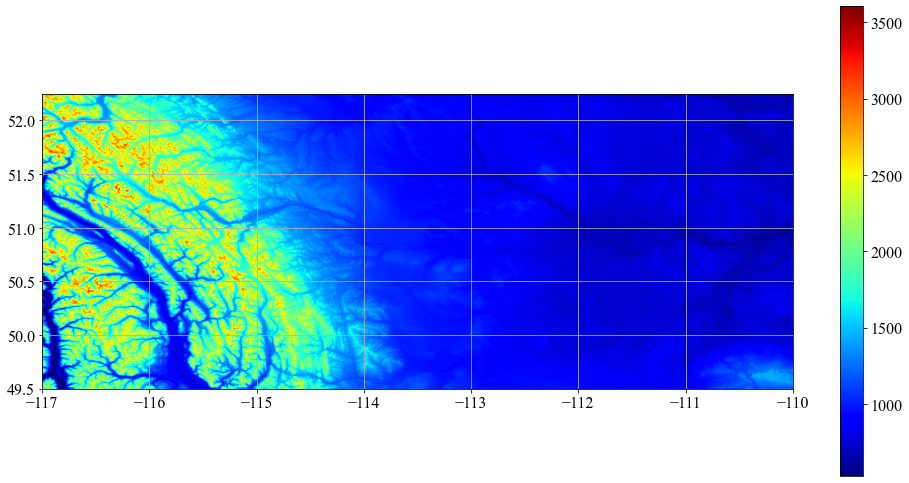

In [1]:
# loading candex
from candex.candex import candex

# initializing candex object
cndx = candex()

shp = cndx.zonal_stat('../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp',
                      '../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff.tif')

print(shp)

shp.plot(column = 'mean')




[4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 429496

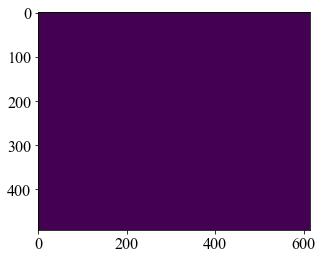

In [15]:

# cndx.visualize_tiff ('../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff.tif')

# cndx.visualize_tiff ('../data/land_cover/land_classes.tif')

import gdal
import matplotlib.pyplot as plt


from osgeo import gdal
ds = gdal.Open('../data/land_cover/land_classes.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
img_array = rb.ReadAsArray()

plt.imshow (img_array)
print(img_array[0])
# print(data)


529.0 3604.4001


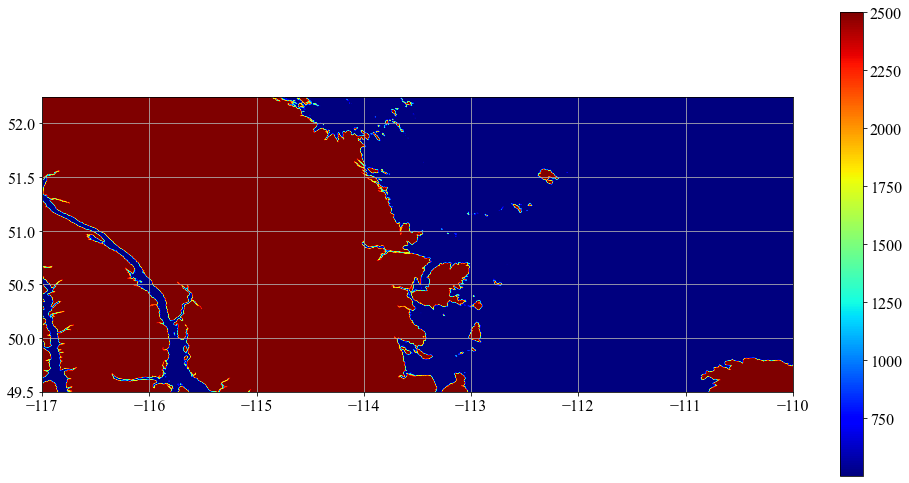

In [18]:
# to the point values
import numpy as np

cndx.geotiff_zones( '../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff.tif',
                   '../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff_out.tif', slice_level = np.array([1,1000,4000]))
cndx.visualize_tiff ('../data/MERIT_HYDRO_dem/MERIT_Hydro_dem_BowAboveBanff_out.tif')

<bound method Dataset.GetProjection of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa26bbb8630> >>
<bound method MajorObject.GetMetadata of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa26bbb8630> >>


In [40]:
import numpy as np
import pandas as pd


number = 100000

tolerance = 10**-5

lon = np.random.random(number) *360 - 180
lat = np.random.random(number) *180 - 90

coord_org    = pd.DataFrame()
coord_pertub = pd.DataFrame()

coord_org ['lon'] = np.random.random(number) *360 - 180
coord_org ['lat'] = np.random.random(number) *180 - 90


coord_pertub ['lon'] = coord_org ['lon'] + (np.random.random(number) * 2 +(-1)) * 10**-6
coord_pertub ['lat'] = coord_org ['lat'] + (np.random.random(number) * 2 +(-1)) * 10**-6


idx = np.random.choice(number, 10000, replace=True)

coord_pertub_sub = coord_pertub.loc[idx]

coord_pertub_sub = coord_pertub_sub.reset_index()
print(coord_pertub_sub)
coord_pertub_sub = coord_pertub_sub.drop(columns = 'index')
print(coord_pertub_sub)

      index         lon        lat
0     45046  170.646399 -70.045694
1      9390  -36.694744  56.516935
2     78873 -134.840576  86.038576
3     56253  179.807811  63.337342
4     19605   47.382294 -45.818256
...     ...         ...        ...
9995  87437    1.704767  54.166100
9996  29885  -54.617973 -53.545378
9997  71355  -84.185036  53.802608
9998  17646   61.628831 -75.798695
9999  94749  -27.884053  86.484675

[10000 rows x 3 columns]
             lon        lat
0     170.646399 -70.045694
1     -36.694744  56.516935
2    -134.840576  86.038576
3     179.807811  63.337342
4      47.382294 -45.818256
...          ...        ...
9995    1.704767  54.166100
9996  -54.617973 -53.545378
9997  -84.185036  53.802608
9998   61.628831 -75.798695
9999  -27.884053  86.484675

[10000 rows x 2 columns]


In [41]:

coord_org = coord_org.sort_values(by='lon')
coord_org = coord_org.sort_values(by='lat')

print(coord_org)

coord_pertub_sub = coord_pertub_sub.sort_values(by='lon')
coord_pertub_sub = coord_pertub_sub.sort_values(by='lat')

print(coord_pertub_sub)


              lon        lat
59917 -136.546945 -89.998995
98348  155.542053 -89.997824
28079  -94.507066 -89.996622
51301   23.977988 -89.995689
35067  -30.059105 -89.991981
...           ...        ...
51751  -29.475268  89.996184
30186   92.416580  89.997195
23757   22.108694  89.999818
90357   88.973830  89.999826
39139  -51.151821  89.999875

[100000 rows x 2 columns]
             lon        lat
352   176.371109 -89.899095
1235  -76.954666 -89.897448
6251 -162.056619 -89.893589
1884   77.011908 -89.869740
8232  143.301363 -89.843166
...          ...        ...
991   162.624156  89.887665
8142   -5.260502  89.899392
5169   50.686753  89.912993
6519   69.142149  89.956495
1964 -125.112906  89.978470

[10000 rows x 2 columns]


In [65]:
coord_org_temp = np.array(coord_org)


for index, row in coord_pertub_sub.iterrows():
    
    #print(index)
    
    # get the distance
    lat_target = row.lat
    lon_target = row.lon
    
    Dist = np.array(((coord_org_temp[:,1] - lat_target)**2 + (coord_org_temp[:,0] - lon_target)**2)**0.5)
    
    #print(Dist)
    
    idx_target = np.where(Dist<tolerance)
    
    
    #print(idx_target)
    
    idx_target = np.array(idx_target)
    idx_target = idx_target.flatten()
    
    if idx_target.shape[0] > 1:
        a = 1
        #print('worng!')
    
    if idx_target.shape[0] == 1:
        
        idx_target = idx_target.item()
        
        #print('right!')
        print(idx_target)
        
        coord_org_temp = coord_org_temp[idx_target:]
        
    print(len(coord_org_temp))
    


    
    

60
99940
2
99938
3
99935
9
99926
12
99914
16
99898
12
99886
10
99876
3
99873
18
99855
4
99851
21
99830
11
99819
2
99817
6
99811
4
99807
10
99797
1
99796
3
99793
2
99791
0
99791
34
99757
19
99738
4
99734
14
99720
60
99660
1
99659
13
99646
5
99641
9
99632
20
99612
9
99603
7
99596
6
99590
12
99578
4
99574
18
99556
2
99554
9
99545
13
99532
1
99531
12
99519
0
99519
14
99505
2
99503
9
99494
17
99477
6
99471
25
99446
16
99430
4
99426
13
99413
13
99400
13
99387
0
99387
11
99376
3
99373
0
99373
11
99362
10
99352
4
99348
8
99340
18
99322
13
99309
27
99282
2
99280
10
99270
29
99241
5
99236
9
99227
6
99221
34
99187
3
99184
7
99177
3
99174
9
99165
9
99156
5
99151
9
99142
17
99125
13
99112
1
99111
5
99106
7
99099
6
99093
7
99086
10
99076
28
99048
8
99040
19
99021
3
99018
6
99012
9
99003
26
98977
4
98973
11
98962
3
98959
5
98954
8
98946
1
98945
2
98943
13
98930
35
98895
29
98866
15
98851
1
98850
12
98838
11
98827
6
98821
11
98810
15
98795
3
98792
13
98779
2
98777
22
98755
23
98732
6
98726
2
98724
13


5
90000
24
89976
2
89974
17
89957
2
89955
7
89948
6
89942
25
89917
1
89916
4
89912
14
89898
1
89897
4
89893
2
89891
5
89886
6
89880
19
89861
4
89857
11
89846
2
89844
0
89844
17
89827
10
89817
6
89811
2
89809
42
89767
13
89754
12
89742
11
89731
16
89715
5
89710
5
89705
6
89699
5
89694
39
89655
8
89647
20
89627
6
89621
30
89591
6
89585
3
89582
4
89578
8
89570
1
89569
7
89562
16
89546
34
89512
1
89511
26
89485
14
89471
2
89469
1
89468
2
89466
30
89436
4
89432
1
89431
3
89428
2
89426
1
89425
20
89405
5
89400
9
89391
1
89390
0
89390
1
89389
1
89388
3
89385
5
89380
13
89367
5
89362
40
89322
7
89315
39
89276
8
89268
19
89249
5
89244
20
89224
3
89221
2
89219
14
89205
24
89181
6
89175
5
89170
11
89159
9
89150
9
89141
11
89130
12
89118
26
89092
8
89084
10
89074
32
89042
3
89039
35
89004
10
88994
21
88973
2
88971
8
88963
4
88959
9
88950
7
88943
2
88941
5
88936
14
88922
3
88919
23
88896
2
88894
5
88889
2
88887
1
88886
21
88865
7
88858
27
88831
7
88824
2
88822
15
88807
14
88793
0
88793
18
88775
4
8

3
78939
13
78926
0
78926
5
78921
37
78884
23
78861
7
78854
55
78799
1
78798
11
78787
9
78778
2
78776
16
78760
4
78756
1
78755
10
78745
3
78742
8
78734
4
78730
11
78719
8
78711
6
78705
5
78700
5
78695
4
78691
24
78667
5
78662
13
78649
15
78634
19
78615
9
78606
0
78606
2
78604
1
78603
5
78598
1
78597
12
78585
29
78556
15
78541
3
78538
17
78521
8
78513
2
78511
37
78474
9
78465
15
78450
56
78394
7
78387
4
78383
26
78357
5
78352
1
78351
17
78334
31
78303
1
78302
26
78276
17
78259
9
78250
0
78250
3
78247
14
78233
11
78222
0
78222
0
78222
19
78203
11
78192
4
78188
6
78182
13
78169
1
78168
24
78144
20
78124
1
78123
1
78122
7
78115
0
78115
5
78110
4
78106
5
78101
2
78099
1
78098
3
78095
13
78082
13
78069
11
78058
5
78053
10
78043
1
78042
2
78040
2
78038
8
78030
8
78022
5
78017
29
77988
23
77965
6
77959
15
77944
17
77927
1
77926
28
77898
2
77896
10
77886
19
77867
7
77860
1
77859
32
77827
1
77826
16
77810
6
77804
7
77797
9
77788
9
77779
31
77748
14
77734
5
77729
17
77712
7
77705
12
77693
3
77690


18
68077
3
68074
0
68074
10
68064
10
68054
1
68053
39
68014
4
68010
23
67987
10
67977
11
67966
5
67961
1
67960
48
67912
5
67907
4
67903
3
67900
2
67898
1
67897
7
67890
7
67883
0
67883
3
67880
1
67879
5
67874
12
67862
18
67844
13
67831
12
67819
1
67818
1
67817
1
67816
4
67812
7
67805
1
67804
20
67784
21
67763
2
67761
5
67756
10
67746
8
67738
5
67733
17
67716
3
67713
10
67703
2
67701
10
67691
3
67688
1
67687
1
67686
3
67683
18
67665
1
67664
2
67662
10
67652
3
67649
9
67640
1
67639
2
67637
37
67600
7
67593
4
67589
34
67555
13
67542
6
67536
27
67509
9
67500
20
67480
1
67479
2
67477
2
67475
2
67473
12
67461
4
67457
19
67438
6
67432
13
67419
9
67410
9
67401
5
67396
18
67378
3
67375
33
67342
4
67338
1
67337
4
67333
1
67332
2
67330
3
67327
10
67317
12
67305
4
67301
5
67296
18
67278
19
67259
7
67252
21
67231
5
67226
34
67192
8
67184
4
67180
0
67180
7
67173
7
67166
14
67152
9
67143
4
67139
11
67128
3
67125
13
67112
3
67109
16
67093
2
67091
22
67069
2
67067
35
67032
4
67028
5
67023
4
67019
0
6701

17
55852
32
55820
20
55800
5
55795
20
55775
11
55764
22
55742
56
55686
14
55672
11
55661
0
55661
12
55649
1
55648
4
55644
2
55642
10
55632
5
55627
6
55621
3
55618
3
55615
6
55609
1
55608
6
55602
2
55600
6
55594
6
55588
3
55585
1
55584
52
55532
4
55528
6
55522
1
55521
8
55513
16
55497
26
55471
12
55459
17
55442
8
55434
2
55432
15
55417
3
55414
4
55410
23
55387
1
55386
1
55385
1
55384
2
55382
14
55368
8
55360
2
55358
13
55345
10
55335
5
55330
2
55328
50
55278
43
55235
14
55221
8
55213
2
55211
16
55195
19
55176
1
55175
2
55173
17
55156
3
55153
3
55150
25
55125
7
55118
13
55105
10
55095
6
55089
8
55081
24
55057
35
55022
2
55020
7
55013
15
54998
8
54990
3
54987
10
54977
11
54966
8
54958
0
54958
13
54945
5
54940
3
54937
3
54934
24
54910
36
54874
5
54869
20
54849
1
54848
9
54839
18
54821
1
54820
10
54810
2
54808
14
54794
5
54789
4
54785
0
54785
25
54760
13
54747
24
54723
28
54695
9
54686
11
54675
4
54671
31
54640
17
54623
12
54611
5
54606
4
54602
11
54591
6
54585
2
54583
12
54571
4
54567
2
54

1
45699
10
45689
6
45683
1
45682
30
45652
8
45644
10
45634
13
45621
11
45610
13
45597
9
45588
14
45574
12
45562
9
45553
1
45552
8
45544
16
45528
2
45526
3
45523
55
45468
1
45467
8
45459
31
45428
1
45427
12
45415
1
45414
1
45413
21
45392
1
45391
10
45381
6
45375
4
45371
1
45370
15
45355
22
45333
50
45283
2
45281
6
45275
10
45265
1
45264
13
45251
4
45247
5
45242
0
45242
9
45233
1
45232
3
45229
10
45219
18
45201
17
45184
19
45165
31
45134
28
45106
10
45096
12
45084
11
45073
1
45072
8
45064
34
45030
11
45019
4
45015
24
44991
13
44978
7
44971
17
44954
34
44920
33
44887
11
44876
12
44864
13
44851
3
44848
17
44831
5
44826
18
44808
0
44808
22
44786
10
44776
8
44768
8
44760
2
44758
18
44740
22
44718
8
44710
8
44702
31
44671
4
44667
45
44622
38
44584
8
44576
2
44574
10
44564
3
44561
5
44556
4
44552
12
44540
4
44536
22
44514
10
44504
5
44499
24
44475
5
44470
11
44459
5
44454
0
44454
5
44449
7
44442
8
44434
1
44433
25
44408
6
44402
6
44396
30
44366
10
44356
3
44353
10
44343
7
44336
20
44316
0
4431

9
35417
6
35411
26
35385
7
35378
0
35378
0
35378
1
35377
27
35350
29
35321
9
35312
6
35306
15
35291
4
35287
18
35269
13
35256
13
35243
4
35239
29
35210
2
35208
10
35198
33
35165
5
35160
35
35125
1
35124
2
35122
1
35121
16
35105
1
35104
6
35098
38
35060
1
35059
8
35051
1
35050
22
35028
14
35014
13
35001
40
34961
9
34952
29
34923
16
34907
23
34884
0
34884
37
34847
2
34845
4
34841
19
34822
2
34820
21
34799
7
34792
35
34757
16
34741
0
34741
34
34707
5
34702
1
34701
0
34701
1
34700
2
34698
16
34682
10
34672
16
34656
33
34623
19
34604
1
34603
18
34585
32
34553
6
34547
2
34545
18
34527
35
34492
59
34433
20
34413
7
34406
1
34405
6
34399
9
34390
18
34372
21
34351
1
34350
0
34350
1
34349
11
34338
2
34336
9
34327
36
34291
20
34271
8
34263
8
34255
8
34247
3
34244
3
34241
0
34241
4
34237
21
34216
4
34212
21
34191
10
34181
29
34152
3
34149
22
34127
45
34082
3
34079
4
34075
2
34073
3
34070
2
34068
0
34068
15
34053
16
34037
6
34031
0
34031
4
34027
8
34019
18
34001
5
33996
23
33973
1
33972
26
33946
2
3

18
23414
19
23395
6
23389
6
23383
2
23381
0
23381
4
23377
3
23374
3
23371
9
23362
14
23348
7
23341
0
23341
8
23333
1
23332
5
23327
1
23326
3
23323
7
23316
2
23314
3
23311
5
23306
31
23275
17
23258
20
23238
2
23236
5
23231
19
23212
28
23184
7
23177
4
23173
24
23149
23
23126
18
23108
7
23101
12
23089
33
23056
0
23056
4
23052
21
23031
1
23030
14
23016
22
22994
10
22984
5
22979
12
22967
1
22966
4
22962
6
22956
38
22918
22
22896
5
22891
4
22887
3
22884
6
22878
35
22843
1
22842
19
22823
19
22804
6
22798
23
22775
7
22768
7
22761
17
22744
21
22723
3
22720
30
22690
6
22684
2
22682
20
22662
4
22658
0
22658
25
22633
17
22616
3
22613
9
22604
12
22592
10
22582
6
22576
7
22569
2
22567
6
22561
12
22549
12
22537
7
22530
0
22530
7
22523
1
22522
4
22518
8
22510
21
22489
2
22487
39
22448
0
22448
7
22441
17
22424
4
22420
14
22406
53
22353
9
22344
34
22310
8
22302
12
22290
8
22282
9
22273
11
22262
13
22249
26
22223
27
22196
28
22168
4
22164
5
22159
4
22155
5
22150
17
22133
5
22128
10
22118
7
22111
13
22098

16
11816
10
11806
15
11791
0
11791
3
11788
8
11780
16
11764
5
11759
8
11751
5
11746
16
11730
19
11711
13
11698
3
11695
12
11683
12
11671
0
11671
13
11658
9
11649
13
11636
8
11628
4
11624
8
11616
9
11607
3
11604
26
11578
1
11577
8
11569
4
11565
11
11554
18
11536
3
11533
10
11523
21
11502
24
11478
29
11449
6
11443
2
11441
3
11438
21
11417
8
11409
40
11369
6
11363
3
11360
17
11343
1
11342
40
11302
1
11301
11
11290
4
11286
12
11274
16
11258
5
11253
5
11248
1
11247
8
11239
2
11237
16
11221
11
11210
15
11195
1
11194
3
11191
19
11172
11
11161
2
11159
1
11158
9
11149
1
11148
5
11143
4
11139
5
11134
4
11130
21
11109
6
11103
16
11087
10
11077
1
11076
2
11074
1
11073
5
11068
8
11060
11
11049
2
11047
0
11047
11
11036
10
11026
8
11018
6
11012
7
11005
2
11003
12
10991
2
10989
1
10988
6
10982
6
10976
15
10961
0
10961
19
10942
33
10909
0
10909
4
10905
5
10900
21
10879
8
10871
1
10870
2
10868
14
10854
11
10843
9
10834
10
10824
3
10821
4
10817
3
10814
0
10814
6
10808
1
10807
1
10806
8
10798
3
10795
6
10

In [66]:
print(coord_org)

print(coord_pertub_sub)


              lon        lat
59917 -136.546945 -89.998995
98348  155.542053 -89.997824
28079  -94.507066 -89.996622
51301   23.977988 -89.995689
35067  -30.059105 -89.991981
...           ...        ...
51751  -29.475268  89.996184
30186   92.416580  89.997195
23757   22.108694  89.999818
90357   88.973830  89.999826
39139  -51.151821  89.999875

[100000 rows x 2 columns]
             lon        lat
352   176.371109 -89.899095
1235  -76.954666 -89.897448
6251 -162.056619 -89.893589
1884   77.011908 -89.869740
8232  143.301363 -89.843166
...          ...        ...
991   162.624156  89.887665
8142   -5.260502  89.899392
5169   50.686753  89.912993
6519   69.142149  89.956495
1964 -125.112906  89.978470

[10000 rows x 2 columns]
